In [211]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

In [1]:
adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Posterior_Section_2")
adata.var_ndames_make_unique()
adata
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

NameError: name 'sc' is not defined

<AxesSubplot:xlabel='n_genes_by_counts'>

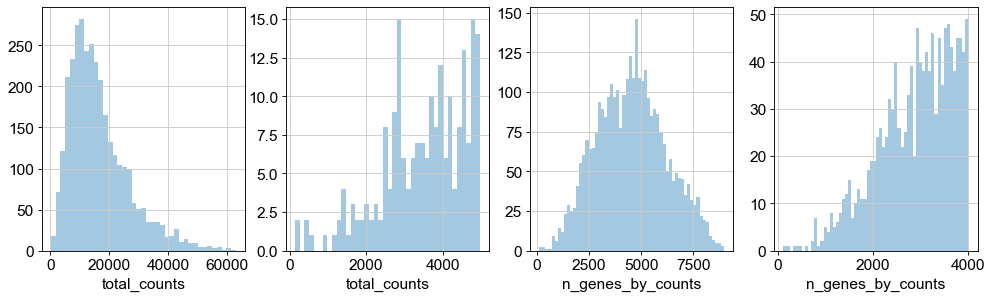

In [193]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 5000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [194]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, max_counts=60000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 6 cells that have less than 1000 counts
filtered out 3 cells that have more than 60000 counts
filtered out 15348 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


#cells after MT filter: 3280


In [195]:
sc.pp.normalize_total(adata, inplace=True, target_sum = 1e6)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [259]:
df_disper = pd.DataFrame(adata.var['dispersions'])
log_x = adata.var['log1p_mean_counts'] #logarithmize mean counts
log_y = df_disper.applymap(lambda x: np.log(x+1)) #logarithmize dispersions
x = adata.var['means']
y = adata.var['dispersions']

[Text(0.5, 0, 'mean expression'), Text(0, 0.5, 'dispersions')]

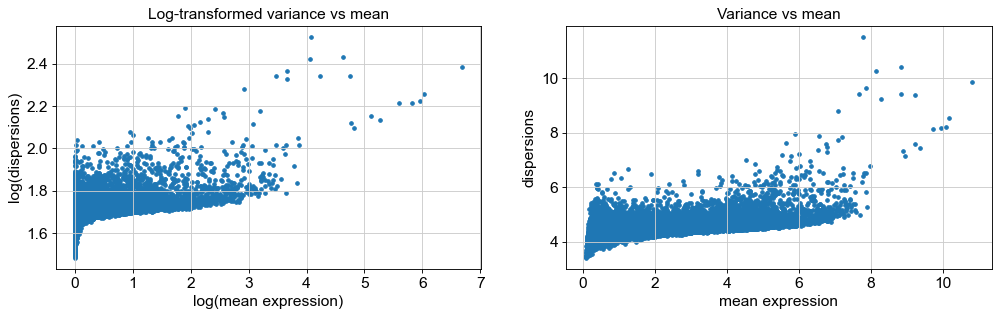

In [255]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.scatter(logx, logy, s= 10)
ax1.set_title("Log-transformed variance vs mean")
ax1.set(xlabel= "log(mean expression)", ylabel="log(dispersions)")
ax2.scatter(x, y, s=10)
ax2.set_title("Variance vs mean")
ax2.set(xlabel= "mean expression", ylabel="dispersions")

In [263]:
df_hvg = pd.DataFrame(adata.var['highly_variable'])
hvg = df_hvg.loc[df_hvg['highly_variable'] == True]
print(hvg)

         highly_variable
St18                True
Vxn                 True
Sgk3                True
Sulf1               True
Slco5a1             True
...                  ...
Gm21887             True
Gm47283             True
mt-Co1              True
mt-Atp8             True
mt-Nd5              True

[3000 rows x 1 columns]


In [266]:
sc.pp.pca(adata) # taking PCA dimensionality reduction
sc.pp.neighbors(adata)
sc.tl.umap(adata) # taking UMAP dimensionality reduction
sc.tl.leiden(adata, key_added="clusters") #graph based clustering based on gene expression profile using leiden method

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 15 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


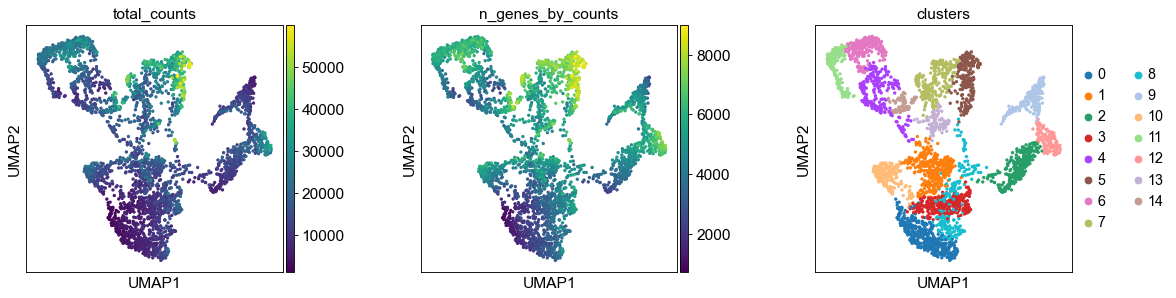

In [267]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts","clusters"], wspace=0.4)

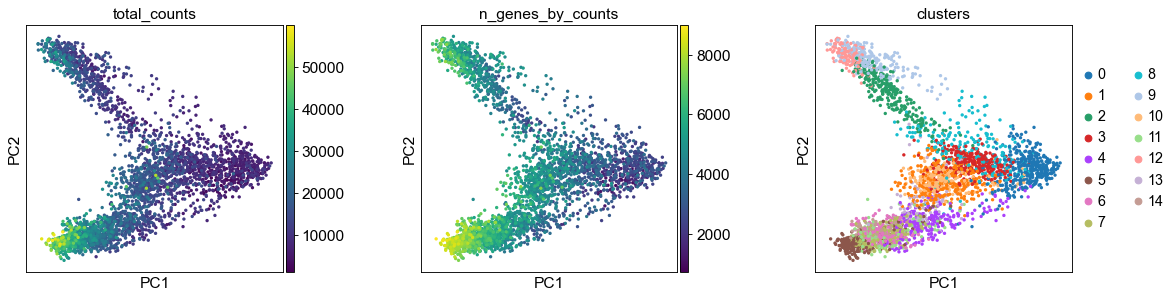

In [268]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.pca(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

Based on the dimension reduction result, visualize the data in a low dimensional embedding and annotate the clusters based on the expression profile similarity. Please specify the clustering method you used and its advantages/disadvantages.

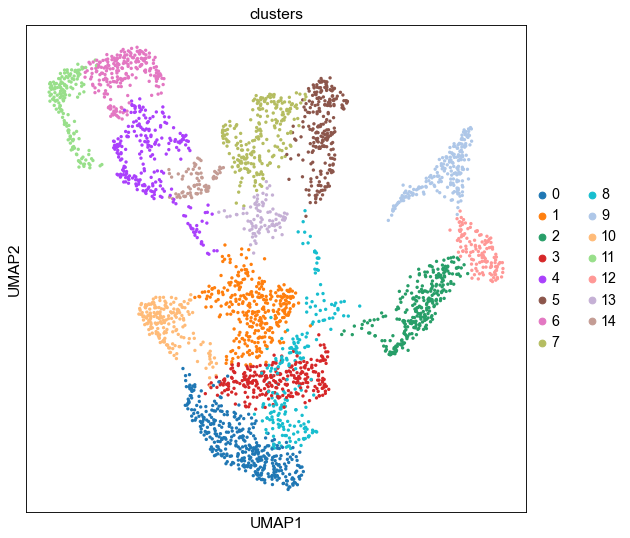

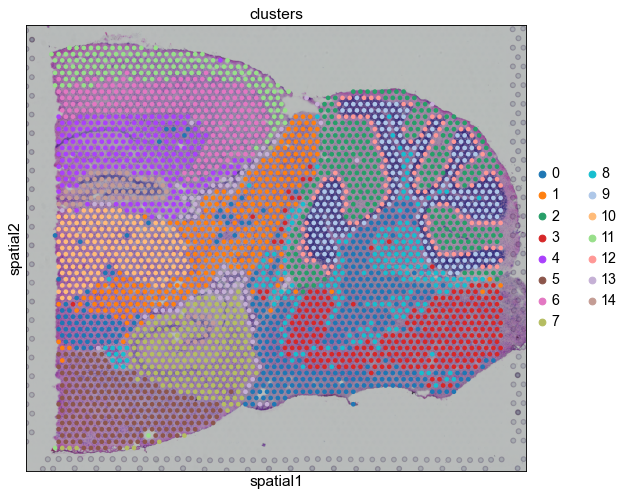

In [275]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.umap(adata, color = ['clusters'])
sc.pl.spatial(adata, img_key="hires", color=["clusters"])

In [350]:
ncounts_per_cluster = adata.obs.groupby(['clusters']).agg({'n_counts' : "sum"}) # Sum of number of cells per clusters
print(ncounts_per_cluster)
print("___________________")
print("max")
print(ncounts_per_cluster.max())

           n_counts
clusters           
0         2377993.0
1         4585898.0
2         3324486.0
3         2647792.0
4         3384823.0
5         8688802.0
6         5652732.0
7         6150635.0
8         2805851.0
9         2308862.0
10        2694492.0
11        2930592.0
12        2781070.0
13        1797990.0
14        1975988.0
___________________
max
n_counts    8688802.0
dtype: float32


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


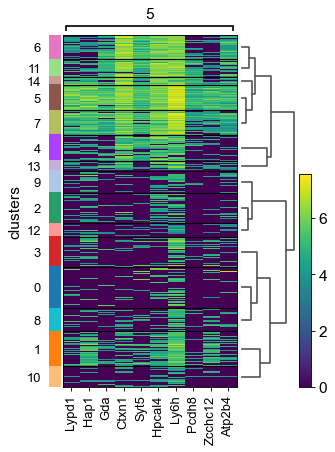

In [276]:
# Using t-test to identify genes that are up-regulated in cluster 5 to compare expression levels across all the clusters
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters") # heatmap showing expression levels of the top 10 up-regulated genes across all the clusters

In [ ]:
from truncated_normal import truncated_normal as tn

In [353]:
pip install truncated_normal

  Created wheel for truncated-normal: filename=truncated_normal-0.4-py3-none-any.whl size=7575 sha256=773fc07c1d613b58d83d33a39de1c775fd40d91bcb89c58b24e512da89f282e7
  Stored in directory: /Users/dankim/Library/Caches/pip/wheels/51/26/1a/ae12aa5abc6589a3f00de5b6c3cb2c156d70bad3b462572978
Successfully built truncated-normal
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [354]:
import os
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind

def plot_labels_legend(x1, x2, Y):
    for i in np.unique(Y):
        plt.plot(x1[Y == i], x2[Y == i], '.',
                 label=r'%s ($n$ = %s)'%(i, np.sum(Y==i)))
    plt.legend()

In [373]:
X = adata.X
features = np.array(adata.var['gene_ids'].index)
tsne = adata.obsm["X_umap"] 

In [378]:
def scanpy_cluster(X, features, tsne=None, plot=False, resolution=1.0):
    "Scanpy implementation of Seurat's pipeline"

    adata = sc.AnnData(X=X)
    adata.var['genes_ids'] = features

    # preprocessing
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    sc.pp.scale(adata, max_value=10)

    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata, resolution=resolution)
    
    if plot:
        if tsne is not None:
            adata.obsm['X_tsne'] = tsne
        else:
            sc.tl.tsne(adata)
        sc.pl.tsne(adata, color=['leiden'])

    labels = np.array(adata.obs['leiden'].astype(int))
    
    return labels

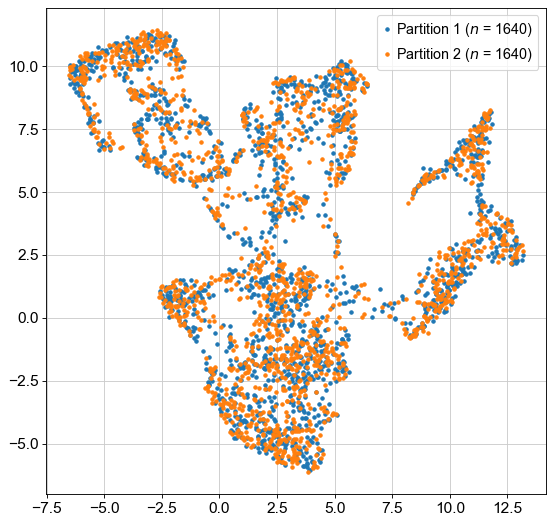

In [379]:
np.random.seed(0)
n = X.shape[0]
inds1 = np.sort(np.random.choice(range(n), n//2, replace=False))
inds2 = np.ones(n).astype(bool)
inds2[inds1] = False
X1, X2 = X[inds1], X[inds2]

samp_labels = np.array(['Partition 1' if i else 'Partition 2' for i in inds2])
plot_labels_legend(tsne[:, 0], tsne[:, 1], samp_labels)

filtered out 20 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster lab

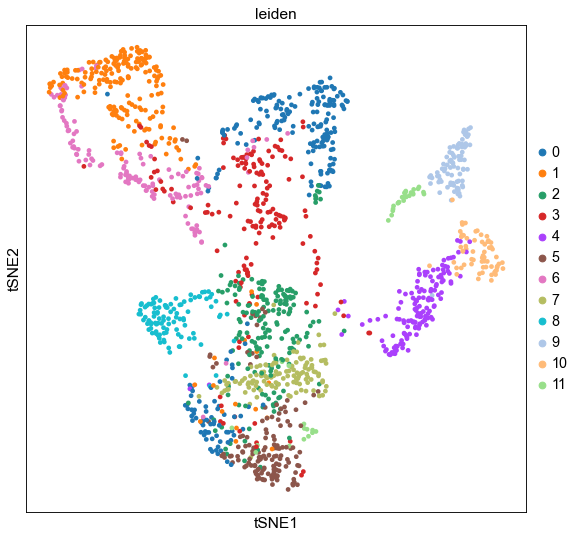

In [382]:
labels1 = scanpy_cluster(X1, features, tsne=tsne[inds1], plot=True, resolution=1)

In [383]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=100)
svm.fit(X1, labels1)

SVC(C=100, kernel='linear')

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.umap(adata, color = ['clusters'])
sc.pl.umap(adata, color = ['clusters'])


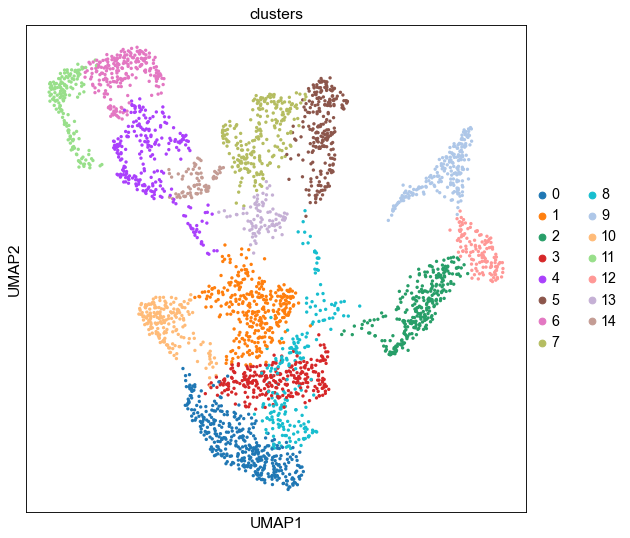

In [437]:
sc.pl.umap(adata, color = ['clusters']) # Clustering using Leiden method

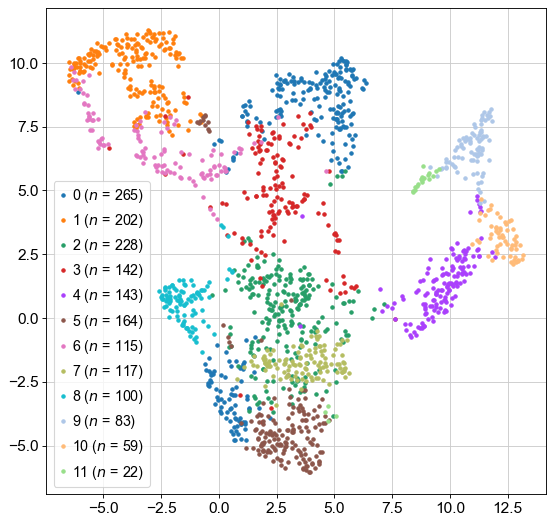

In [384]:
labels2 = svm.predict(X2)
plot_labels_legend(tsne[inds2, 0], tsne[inds2, 1], labels2) # Truncated 

In [ ]:
# np.set_printoptions(precision=2)
# for i in range(5):
#     print(i, np.mean(np.dot(X2[labels2 == i], svm.coef_.T) + svm.intercept_ > 0, 0))

np.random.seed(0)

picklefile = 'pbmc_tntest_tutorial.pickle'
if os.path.isfile(picklefile):
    results = pickle.load(open(picklefile, 'rb'))
else:
    results = {}
    
start = time.time()
for i in range(12):
    c1 = 0
    c2 = i
    p_t = ttest_ind(X1[labels1 == c1].todense(), X1[labels1 == c2].todense())[1]
    p_t[np.isnan(p_t)] = 1
    y = np.array(X2[labels2 == c1].todense())
    z = np.array(X2[labels2 == c2].todense())
    a = np.array(svm.coef_[i].todense()).reshape(-1)
    b = svm.intercept_[i]
    p_tn, likelihood = tn.tn_test(y, z, a=a, b=b,
                                  learning_rate=1.,
                                  eps=1e-2,
                                  verbose=True,
                                  return_likelihood=True,
                                  num_iters=100000,
                                  num_cores=64)
    results[(c1, c2)] = (p_t, p_tn)
    print('c1: %5s\tc2: %5s\ttime elapsed: %.2fs'%(c1, c2, time.time()-start))
    pickle.dump(results, open(picklefile, 'wb'))

Number of genes with 0 variance across cells: 438
100000 iterations done; likelihood = -6.18e+06 (315.49 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   32.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  5.5min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  7.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  9.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 11.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 13.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 16.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 19.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 22.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 25.4min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     0	time elapsed: 2490.65s
Number of genes with 0 variance across cells: 204
38855 iterations done; likelihood = -5.13e+06 (117.50 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   42.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.8min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 10.1min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 15.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 17.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 20.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 23.5min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     1	time elapsed: 4703.68s
Number of genes with 0 variance across cells: 149
41229 iterations done; likelihood = -5.49e+06 (123.49 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   42.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.7min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 16.9min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.6min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     2	time elapsed: 6867.99s
Number of genes with 0 variance across cells: 132
14510 iterations done; likelihood = -4.78e+06 (43.60 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   43.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.8min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 10.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.6min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 17.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.9min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.9min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     3	time elapsed: 8976.32s
Number of genes with 0 variance across cells: 234
31650 iterations done; likelihood = -4.63e+06 (95.08 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   45.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.9min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.4min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 10.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 17.0min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.7min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     4	time elapsed: 11108.40s
Number of genes with 0 variance across cells: 257
32686 iterations done; likelihood = -4.68e+06 (96.17 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   11.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   41.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.6min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  7.8min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  9.7min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 11.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 16.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.2min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     5	time elapsed: 13207.88s
Number of genes with 0 variance across cells: 298
46446 iterations done; likelihood = -4.29e+06 (135.62 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   42.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.8min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 16.9min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.7min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     6	time elapsed: 15374.65s
Number of genes with 0 variance across cells: 289
33004 iterations done; likelihood = -4.27e+06 (107.47 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   42.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.7min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  7.9min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 14.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 16.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 19.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed: 22.5min
[Parallel(n_jobs=64)]: Done 12672 tasks    


c1:     0	c2:     7	time elapsed: 17511.24s
Number of genes with 0 variance across cells: 300
1350 iterations done; likelihood = -4.04e+06 (5.61 s elapsed).


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   43.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  4.8min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  6.6min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  8.4min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed: 10.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed: 12.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed: 15.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed: 17.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed: 20.9min


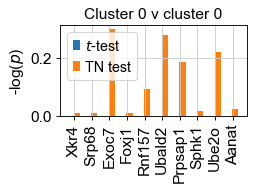

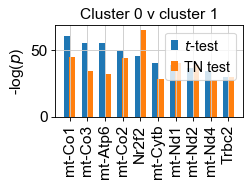

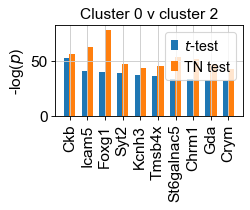

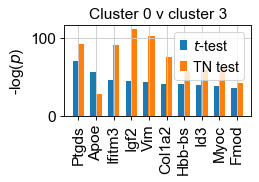

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


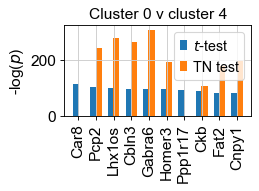

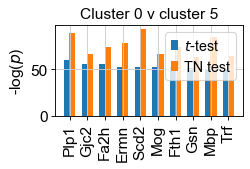

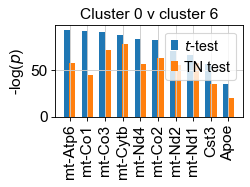

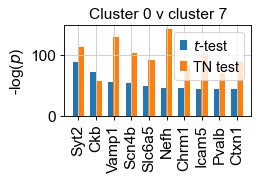

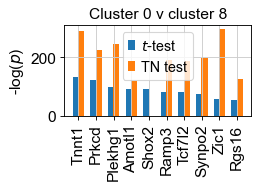

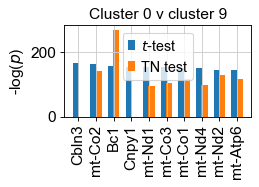

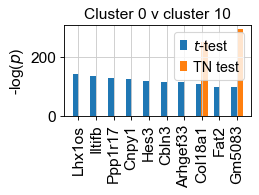

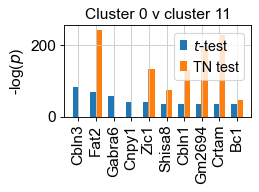

In [430]:
# visualize results of the differential expression analysis
ngenes = 10
ind = np.arange(ngenes)

for c1, c2 in sorted(results):
    p_t, p_tn = results[(c1, c2)]
    gene_inds = np.argsort(p_t)[:ngenes]
    gene_names = features[gene_inds]
    
    fig, ax = plt.subplots(figsize=(3, 1.5))
    rects = ax.bar(ind-0.2,
                   -np.log10(p_t[gene_inds]), 
                   0.35,
                   align='center',
                   label=r'$t$-test')
    rects = ax.bar(ind-0.2+0.3,
                   -np.log10(p_tn[gene_inds]),
                   0.35,
                   align='center',
                   label='TN test')
    ax.set_ylabel('-log($p$)')
    xticks_pos = [0.65*patch.get_width()+patch.get_xy()[0]-0.2 for patch in rects]
    plt.xticks(np.array(xticks_pos), gene_names, rotation=90)
    plt.legend()
    plt.title('Cluster %s v cluster %s'%(c1, c2))
    plt.show()

In [385]:
def tn_test_framework(X, clustering_algorithm, ngenes=10, verbose=True,
                      **kwargs):
    """
    The TN test framework as described in
    https://www.biorxiv.org/content/early/2018/11/05/463265.

    Parameters
    ----------
    X: input data with dimension (num_cells)-by-(num_features)
    clustering_algorithm: a function that returns labels for input data
        (cells)
    ngenes: number of genes to test (TN test is relatively slow and should
        primarily be used to double-check markers chosen by other methods.
        We compare against t-test by default)

    Returns
    ----------
    X1: first half of dataset used to generate labels
    X2: second half of dataset used to run differential expression analysis
    y1: labels for first half
    y2: labels for second half
    de: dictionary of pairwise differential expression
    """
    
    # Split the dataset
    n = X.shape[0]
    inds1 = np.sort(np.random.choice(range(n), n//2, replace=False))
    inds2 = np.ones(n).astype(bool)
    inds2[inds1] = False
    X1, X2 = X[inds1], X[inds2]
    
    # Clustering
    y1 = clustering_algorithm(X1)
    
    # Fit linear separator using X1
    svm = SVC(kernel='linear', C=100)
    svm.fit(X1, y1)
    
    # Generate labels for X2
    y2 = svm.predict(X2)
    
    # Perform differential expression
    de = {}
    if verbose:
        start = time.time()
    for i, (c1, c2) in enumerate(itertools.combinations(np.unique(y2), 2)):
        p_t = ttest_ind(X1[y1 == c1].todense(), X1[y1 == c2].todense())[1]
        p_t[np.isnan(p_t)] = 1
        y = np.array(X2[y2 == c1].todense())
        z = np.array(X2[y2 == c2].todense())
        a = np.array(svm.coef_[i].todense()).reshape(-1)
        p_tn = tn.tn_test(y, z, a=a,
                          intercept=svm.intercept_[i],
                          learning_rate=1.,
                          eps=1e-2,
                          verbose=verbose,
                          num_iters=100000,
                          num_cores=64,
                          **kwargs)
        de[(c1, c2)] = (p_t, p_tn)
        if verbose:
            print('c1: %5s\tc2: %5s\ttime elapsed: %.2fs'%(c1, c2, time.time()-start))
            
    return X1, X2, y1, y2, de

In [408]:
pip install spatialde

  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5713 sha256=f86b74db609bd2d7fc022cb4c327b54e5515b8a56a6a2e47e8fe4ecc165f2617
  Stored in directory: /Users/dankim/Library/Caches/pip/wheels/30/a2/ab/46e10ae9515e5c12b77d8f1bbab167dd08cdc24135ad226f31
Successfully built NaiveDE
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [409]:
import SpatialDE

In [413]:
%%time
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)


CPU times: user 2h 9min 43s, sys: 11min 42s, total: 2h 21min 25s
Wall time: 24min 24s


In [414]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [415]:
results.sort_values("qval").head(10) #Genes that spatially varies and sorted by the significance

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
g,,,,,,,,,,,,,,,,,,
Sh3kbp1,0.048174,4,Sh3kbp1,10931.493498,1.480092,-6696.940707,1.545061,2.335225,SE,3280,0.000694,0.263293,0.002578,13426.263809,-6786.256322,89.315615,0.0,0.0
Letmd1,0.090012,4,Letmd1,458.998662,9.890649,-6986.813081,1.589803,0.432121,SE,3280,0.000010,0.001328,0.003744,14006.008556,-7087.402649,100.589569,0.0,0.0
Cox14,0.163614,4,Cox14,458.998662,5.001235,-6344.922068,4.803539,0.844230,SE,3280,0.000016,0.000794,0.004355,12722.226530,-6533.245110,188.323042,0.0,0.0
Gpd1,0.134927,4,Gpd1,458.998662,6.272556,-7298.179074,2.827147,0.859789,SE,3280,0.000017,0.001117,0.003894,14628.740543,-7453.725104,155.546030,0.0,0.0
Faim2,0.205014,4,Faim2,458.998662,3.793723,-6161.832959,5.028429,0.970293,SE,3280,0.000021,0.000776,0.003567,12356.048312,-6362.931137,201.098178,0.0,0.0
Bcdin3d,0.080138,4,Bcdin3d,458.998662,11.229911,-5704.405770,0.516226,0.164961,SE,3280,0.000012,0.001791,0.005532,11441.193935,-5784.838083,80.432313,0.0,0.0
Prpf40b,0.104071,4,Prpf40b,458.998662,8.422380,-7118.333084,1.894612,0.553225,SE,3280,0.000010,0.001059,0.003489,14269.048562,-7249.985264,131.652180,0.0,0.0
Tuba1a,0.258718,4,Tuba1a,458.998662,2.803154,-2452.934311,6.933672,0.786754,SE,3280,0.000020,0.000584,0.003517,4938.251017,-2775.526853,322.592542,0.0,0.0
Tuba1b,0.172619,4,Tuba1b,458.998662,4.689307,-4115.864036,6.368997,0.712167,SE,3280,0.000018,0.000868,0.003713,8264.110468,-4281.050013,165.185976,0.0,0.0


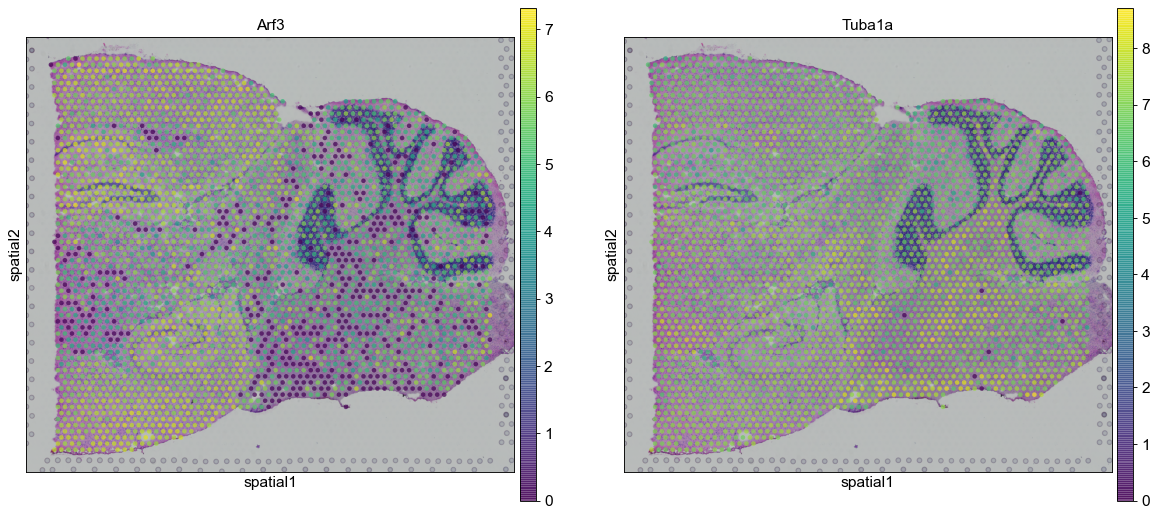

In [436]:
sc.pl.spatial(adata, img_key="hires", color=["Arf3", "Tuba1a"], alpha=0.7) #Visualize gene expression profile of Arf3 and Tuba1a genes that have high FSV value with significance across all spatial coordinates in the brain slice image.